In [ ]:
from typing import Annotated,List
import operator
from typing_extensions import TypedDict
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict



In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_openai import ChatOpenAI
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
llm=ChatOpenAI(model="gpt-4o-mini")

result=llm.invoke("What is the capital of France?")
print(result.content)

/Users/ayushsiddhant/Desktop/Langchain/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AIMessage(content='The capital of France is Paris.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 14, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-CUszXPgbkz66LU2iZ024D2vQimD2D', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--e742f889-6ab4-42c1-b2e3-93227b712760-0', usage_metadata={'input_tokens': 14, 'output_tokens': 7, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [5]:
#Schema for structured output to use in planning
class Section(BaseModel):
    name:str=Field(description="Name for this section of the report")
    description:str=Field(description="Brief overview of the main. topic and concepts of the section")


class Sections(BaseModel):
    sections:List[Section]=Field(
        description="Sections of the report"
    )

#Augment the LLM with schema for structured output
planner=llm.with_structured_output(Sections)

In [12]:
from langgraph.constants import END,START

#Graph State
class State(TypedDict):
    topic:str #Report Topic
    sections:list[Section] #List of report sections
    completed_sections:Annotated[
        list,operator.add
    ]
    final_report:str #Final Report

#Worker State
class WorkerState(TypedDict):
    section:Section
    completed_sections:Annotated[list,operator.add]

In [13]:
from langgraph.types import Send

def orchestrator(state:State):
    """Orchestrator that generates plan for the report"""

    report_sections=planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report"),
            HumanMessage(content=f"Here is the report topic: {state['topic']}")
        ]
        )  

    print("Report Sections:",report_sections)

    return {"sections":report_sections.sections}

def llm_call(state:WorkerState):
    """LLM Call to generate section content"""
    section=llm.invoke(
        [
            SystemMessage(content="Write a report section based on the following instructions"),
            HumanMessage(content=f"Here is the section name: {state['section'].name} and description:{state['section'].description}")
        ]
    )
    return {"completed_sections":[section.content]}

#Conditional edge function to create llm_call workers that each write a section of report
def assign_workers(state:State):
    """Assign workers to generate section in the plan"""

    return [Send("llm_call",{"section":s}) for s in state["sections"]]


def synthesizer(state:State):
    """Synthesize the completed sections into a final report"""
    completed_sections=state["completed_sections"]
    completed_report_sections="\n\n---\n\n".join(completed_sections)
    return {"final_report":completed_report_sections}


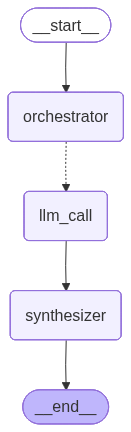

In [14]:
from langgraph.graph import StateGraph,START,END
from IPython.display import Image,display

orchestrator_worker_builder=StateGraph(State)
orchestrator_worker_builder.add_node("orchestrator",orchestrator)
orchestrator_worker_builder.add_node("llm_call",llm_call)
orchestrator_worker_builder.add_node("synthesizer",synthesizer)

orchestrator_worker_builder.add_edge(START,"orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator",assign_workers,["llm_call"]
    )
orchestrator_worker_builder.add_edge("llm_call","synthesizer")
orchestrator_worker_builder.add_edge("synthesizer",END)

graph=orchestrator_worker_builder.compile()

# Visualize the graph
Image(graph.get_graph(xray=True).draw_mermaid_png())




In [17]:
# Test the orchestrator-worker pattern
result = graph.invoke({"topic": "The Impact of Artificial Intelligence on Modern Healthcare"})
print("Final Report:")
from IPython.display import Markdown
Markdown(result["final_report"])


Report Sections: sections=[Section(name='Introduction', description='An overview of the significance of artificial intelligence in contemporary healthcare, highlighting its rapid growth and relevance.'), Section(name='Defining Artificial Intelligence in Healthcare', description='Detailed explanations of what constitutes AI in the context of healthcare, including types like machine learning, natural language processing, and robotics.'), Section(name='Current Applications of AI in Healthcare', description='Explore various practical applications of AI in modern healthcare settings, such as diagnosis, treatment planning, patient management, and personalized medicine.'), Section(name='Benefits of AI in Healthcare', description='Examine the positive impacts of AI, including improved accuracy in diagnostics, enhanced patient care, and increased efficiency in healthcare operations.'), Section(name='Challenges and Ethical Considerations', description='Discuss the potential drawbacks and ethical

### Introduction and Description: Significance of Artificial Intelligence in Contemporary Healthcare

In recent years, artificial intelligence (AI) has emerged as a transformative force in the healthcare sector, heralding a new era characterized by enhanced efficiency, accuracy, and improved patient outcomes. This explosive growth in AI technologies—underpinned by advances in machine learning, data analytics, and natural language processing—has led to an increasing integration of AI tools into various facets of healthcare delivery. As the demand for high-quality medical services intensifies amidst rising healthcare costs and an aging population, the relevance of AI in addressing these challenges cannot be overstated.

The significance of AI in contemporary healthcare can be encapsulated through its ability to analyze vast amounts of data rapidly, providing insights that were previously beyond human capability. AI algorithms can sift through complex datasets ranging from electronic health records to genetic information, identifying patterns and trends that aid in early diagnosis and personalized treatment plans. This capability not only enhances the precision of medical interventions but also facilitates preventive care, shifting the focus from reactive treatment to proactive health management.

Moreover, AI applications extend beyond diagnostics and treatment plans to encompass operational efficiencies within healthcare institutions. By optimizing scheduling, managing supply chains, and improving resource allocation, AI-driven solutions streamline workflows, reduce costs, and ultimately lead to better patient experiences. The rise of telemedicine and AI-enabled virtual health assistants further showcases the technology's potential to provide accessible care, particularly in underserved regions where specialized medical expertise may be limited.

As healthcare continues to navigate the complexities of data privacy, ethical considerations, and regulatory frameworks, the relevance of AI is further amplified by its role in shaping the future of medical research. AI is instrumental in drug discovery, clinical trials, and genomics—accelerating the pace of innovation and ultimately leading to groundbreaking therapies and interventions.

In summary, AI's rapid growth and its multifaceted applications underscore its vital role in contemporary healthcare. By driving efficiencies, enhancing diagnostic accuracy, and fostering innovation, AI stands as a cornerstone of a future where healthcare is not only more effective but also more equitable and accessible for all. As organizations increasingly recognize AI's potential, the healthcare industry is poised to undergo significant transformations that could redefine patient care, practitioner practices, and overall health outcomes.

---

### Defining Artificial Intelligence in Healthcare

Artificial Intelligence (AI) has become an integral component in the evolution of the healthcare sector, significantly enhancing various aspects of patient care, operational efficiency, and medical research. In the context of healthcare, AI can be defined as the simulation of human intelligence processes by machines, particularly computer systems, which can analyze vast amounts of health-related data to aid in decision-making and improve outcomes. Below we explore the primary types of AI technologies utilized within healthcare.

#### Machine Learning
Machine learning (ML), a subset of AI, involves the development of algorithms that allow computers to learn from and make predictions or decisions based on data. In healthcare, ML is used to analyze complex datasets, such as patient records, to identify patterns that can help in diagnosing diseases, predicting patient outcomes, and personalizing treatment plans. For instance, ML algorithms can be trained to detect anomalies in imaging data, enabling early detection of conditions such as cancer or cardiovascular diseases.

#### Natural Language Processing
Natural Language Processing (NLP) is another critical component of AI in healthcare. NLP enables machines to understand, interpret, and respond to human language in a valuable way. This technology is widely applied in managing unstructured data, such as clinical notes and patient reports, allowing healthcare providers to extract pertinent information efficiently. NLP can also facilitate patient engagement through chatbots and virtual health assistants, enhancing communication and information access for patients while reducing the administrative burden on healthcare professionals.

#### Robotics
Robotics encompasses the use of AI to create machines that can assist in various healthcare applications. Robotic systems are increasingly employed for surgical procedures, providing precision beyond human capabilities, thereby enhancing surgical outcomes. Additionally, robots can be used for patient care in rehabilitation settings and to aid in tasks like medication dispensing, which improves operational efficiency. As technology advances, the integration of robots with AI will likely expand, leading to even more innovative applications in patient care and hospital management.

#### Conclusion
The incorporation of AI in healthcare is reshaping the industry by improving diagnostic accuracy, tailoring treatments to individual patient needs, and streamlining operations. As AI technologies like machine learning, natural language processing, and robotics continue to evolve, their potential to enhance healthcare delivery will only grow, promising to revolutionize the way medical professionals interact with patients and manage health information. Through this ongoing transformation, the future of healthcare stands to become increasingly efficient, effective, and accessible.

---

### Current Applications of AI in Healthcare

In recent years, artificial intelligence (AI) has become a transformative force in the healthcare sector, ushering in innovative solutions that enhance the effectiveness and efficiency of patient care. Here, we delve into the various practical applications of AI in contemporary healthcare settings, which span across diagnostics, treatment planning, patient management, and personalized medicine.

#### 1. Diagnosis
AI systems are increasingly being employed for diagnostics, leveraging machine learning algorithms to analyze vast datasets and identify patterns that may not be readily apparent to human practitioners. For example, AI technologies have shown remarkable efficacy in image recognition tasks, particularly in radiology. Systems trained on thousands of images can assist in detecting abnormalities such as tumors in X-rays, MRIs, and CT scans with high accuracy. Additionally, AI-powered diagnostic tools are being developed for other areas such as dermatology, pathology, and cardiology, where they can support clinicians by providing second opinions or flagging potential issues for further examination.

#### 2. Treatment Planning
AI is revolutionizing treatment planning by analyzing patient data and determining optimal treatment paths. By integrating clinical guidelines, recent research, and patient-specific factors, AI algorithms can assist healthcare providers in choosing the most effective interventions. For instance, in oncology, AI can help clinicians create tailored treatment regimens based on an individual patient’s genetic makeup and cancer type, predicting responses to various therapies. This capability is further enhanced by AI systems that analyze patient histories and outcomes to refine treatment plans continuously.

#### 3. Patient Management
In the domain of patient management, AI technologies are streamlining operations and enhancing patient engagement. Smart scheduling systems utilize AI to minimize wait times and optimize the allocation of resources in healthcare facilities, improving overall operational efficiency. Moreover, AI-driven chatbots and virtual health assistants are being deployed to provide patients with timely information, appointment reminders, and guidance on managing their health conditions, thereby fostering better patient compliance and satisfaction.

#### 4. Personalized Medicine
Personalized medicine refers to the tailoring of medical treatment to the individual characteristics of each patient. AI plays a critical role by integrating diverse data sources, including genetic information, lifestyle choices, and environmental factors, to recommend customized therapies. With the advent of AI, the potential for precision medicine has expanded significantly, as algorithms can predict patient responses to various treatments, enabling more targeted and effective interventions. This approach not only improves patient outcomes but also helps in reducing healthcare costs by minimizing trial-and-error in treatment selection.

### Conclusion
The integration of AI in healthcare is steadily reshaping the landscape of medical practice, offering innovative ways to improve diagnosis accuracy, streamline treatment planning, manage patient interactions, and deliver personalized care. As technology continues to evolve, it is anticipated that the applications of AI in healthcare will expand further, paving the way for a more efficient, effective, and patient-centered healthcare system. Continued research and ethical considerations will be essential to maximize the benefits of AI while addressing potential challenges and ensuring equitable access to these advancements across diverse populations.

---

### Benefits of AI in Healthcare

The integration of Artificial Intelligence (AI) into healthcare settings has yielded numerous positive impacts, fundamentally transforming the way healthcare is delivered. Among these benefits, three prominent areas stand out: improved accuracy in diagnostics, enhanced patient care, and increased efficiency in healthcare operations.

**Improved Accuracy in Diagnostics**

AI technologies, particularly machine learning and deep learning algorithms, have significantly enhanced the accuracy of medical diagnoses. By analyzing vast amounts of medical data, including imaging studies, lab results, and electronic health records, AI systems can identify patterns and anomalies with remarkable precision. Studies have shown that AI-driven diagnostic tools can outperform human clinicians in certain contexts, such as radiology, pathology, and dermatology. For instance, AI algorithms have demonstrated higher rates of detecting early-stage cancers in mammograms than traditional methods. The result is not only a reduction in diagnostic errors but also earlier detection of diseases, which can lead to better patient outcomes.

**Enhanced Patient Care**

AI applications in healthcare extend beyond diagnostics to revolutionize patient care. Personalized medicine, powered by AI, allows for tailored treatment plans based on individual patient data, including genetics, lifestyle, and preferences. This patient-centric approach enhances the effectiveness of treatments, ensures better adherence to medical advice, and ultimately leads to improved health outcomes. AI-driven virtual health assistants provide patients with round-the-clock support and information, helping them manage their conditions more effectively. Furthermore, predictive analytics enabled by AI can forecast potential health crises in patients at risk, thereby facilitating timely interventions and preventive measures.

**Increased Efficiency in Healthcare Operations**

Beyond patient-facing applications, AI has the potential to streamline healthcare operations dramatically. Administrative tasks such as scheduling appointments, managing patient flow, and billing can be automated through AI systems, freeing up healthcare professionals to focus on more critical aspects of patient care. AI can also optimize resource allocation, ensuring that facilities are adequately staffed and equipped to meet patient needs. By reducing operational costs and minimizing wait times, AI contributes to a more efficient healthcare delivery system, allowing healthcare providers to improve access to care and enhance the overall patient experience.

In summary, the incorporation of AI in healthcare leads to improved diagnostic accuracy, enhanced patient care through personalization, and increased operational efficiency. As AI technology continues to evolve, its positive impacts on the healthcare sector are expected to grow, paving the way for a more effective and responsive healthcare ecosystem.

---

### Challenges and Ethical Considerations

The integration of artificial intelligence (AI) into healthcare has garnered significant attention, offering promising advancements in diagnostics, treatment personalization, and operational efficiency. However, as AI systems become increasingly involved in healthcare decision-making, several challenges and ethical considerations emerge that must be addressed to harness the technology responsibly and effectively.

#### Data Privacy Issues

One of the foremost concerns surrounding AI in healthcare is the issue of data privacy. Healthcare data is inherently sensitive, encompassing personal information that is protected under various regulations, such as the Health Insurance Portability and Accountability Act (HIPAA) in the United States. The deployment of AI often requires the aggregation and analysis of vast amounts of patient data, raising questions about who has access to this data, how it is stored, and how it is used.

There is a significant risk of data breaches, where unauthorized individuals may access sensitive information, leading to identity theft, discrimination, and other serious consequences for patients. Moreover, with the increasing use of cloud-based systems and third-party vendors for data processing, the chain of custody for patient data becomes more complex, increasing the potential for misuse. As such, healthcare organizations must establish robust data governance policies to ensure compliance with privacy regulations and to safeguard patient autonomy.

#### Biases in Algorithms

Another critical challenge associated with AI in healthcare is the potential for bias in algorithms. AI systems are trained on historical data, which may reflect existing prejudices or disparities within healthcare. For instance, if an AI system learns from data that predominantly features one demographic group, it may struggle to provide equitable care across diverse populations. Such biases can result in misdiagnoses, inappropriate treatment recommendations, and healthcare inequities, thereby exacerbating health disparities rather than alleviating them.

Moreover, the lack of transparency in many AI algorithms complicates efforts to identify and mitigate bias. Healthcare providers must be vigilant in selecting and evaluating AI tools, ensuring that these technologies have been tested for fairness and inclusivity across different demographic groups before deployment.

#### Implications of AI Decision-Making

The use of AI to supplement or even replace human decision-making in healthcare raises profound ethical dilemmas. On one hand, AI's ability to analyze data rapidly and accurately can enhance clinical decision-making, potentially leading to improved patient outcomes. However, this reliance on AI also poses risks regarding accountability and the loss of human oversight. 

When AI systems are responsible for significant healthcare decisions, it becomes challenging to ascertain liability in cases of errors or adverse outcomes. Determining whether the fault lies with the algorithm, the developers, or the healthcare providers who implemented the technology can be a legal and ethical quagmire. Additionally, patients may feel uncomfortable with the prospect of machines making decisions about their care or treatment, leading to a potential erosion of trust in the healthcare system.

As the healthcare industry continues to embrace AI technologies, it is paramount to consider these challenges and ethical implications diligently. Stakeholders must foster a culture of transparency, equity, and accountability to navigate the complexities of AI in healthcare, ensuring that its application aligns with the overarching principles of medical ethics and patient-centered care. Addressing these concerns proactively presents an opportunity not only to advance technological innovation but also to uphold the values of respect, fairness, and integrity that are at the core of the healthcare profession.

---

### Case Studies and Description

As artificial intelligence (AI) continues to advance, numerous organizations have successfully integrated AI technologies into healthcare settings, demonstrating significant improvements in patient outcomes, operational efficiency, and cost reduction. This section highlights real-world examples of such implementations, showcasing the transformative potential of AI in the healthcare sector.

#### 1. **IBM Watson Health**

**Description:** IBM Watson Health leverages advanced AI algorithms to assist healthcare providers in diagnosing and treating patients more effectively. The technology processes vast amounts of data from medical literature, clinical trial results, and patient records to support clinical decision-making.

**Results Achieved:** One of the notable applications of Watson Health is its partnership with oncology providers. By analyzing patient data and medical history, Watson has been able to recommend personalized treatment options for cancer patients. A pilot study demonstrated that Watson's recommendations were concordant with expert oncologists in 96% of cases. This collaboration led to improved treatment pathways, quicker decision-making, and enhanced patient care.

#### 2. **Google DeepMind and Moorfields Eye Hospital**

**Description:** In collaboration with Moorfields Eye Hospital in London, Google DeepMind developed an AI system capable of diagnosing various eye diseases from retinal scans. The AI application uses deep learning algorithms to analyze optical coherence tomography (OCT) images.

**Results Achieved:** The AI system achieved an accuracy of over 90%, matching the performance of highly trained ophthalmologists. In a pilot study, the technology was able to detect conditions such as diabetic retinopathy and age-related macular degeneration, which can lead to blindness if not diagnosed early. This innovation has allowed for expedited diagnosis and treatment, reducing the burden on specialists and enabling timely intervention for patients.

#### 3. **PathAI**

**Description:** PathAI is a technology company focused on improving the accuracy of pathology diagnostics through machine learning. The platform analyzes pathology slides and assists pathologists by identifying potential cancerous lesions with high precision.

**Results Achieved:** In clinical trials, PathAI has recorded accuracy rates of over 94% in detecting breast cancer from pathology images. The increase in diagnostic accuracy has significant implications for treatment planning, as early and accurate detection is crucial in improving survival rates. By minimizing false negatives, PathAI is helping to ensure that patients receive the appropriate treatments in a timely manner.

#### 4. **Babylon Health**

**Description:** Babylon Health is a digital health platform that utilizes AI-driven chatbots to provide medical consultations based on users' symptoms. The service includes virtual consultations with healthcare professionals and offers personalized health assessments.

**Results Achieved:** During a pilot program in the UK, Babylon's AI consultation system demonstrated that it could accurately triage medical conditions, achieving a diagnostic accuracy comparable to traditional consultations. This innovation not only reduces waiting times for patients but also alleviates pressure on healthcare systems by directing patients to the appropriate level of care based on their needs.

#### 5. **Aidoc**

**Description:** Aidoc is an AI-powered radiology solution designed to assist radiologists in identifying and prioritizing critical findings in medical imaging. The technology analyzes CT scans to flag abnormalities that require immediate attention.

**Results Achieved:** Aidoc's AI algorithms have successfully reduced the time radiologists spend on identifying time-sensitive conditions such as hemorrhages and pulmonary embolisms. Clinical studies indicated that the implementation of Aidoc resulted in a reduction of diagnosis time by up to 30%, allowing for quicker interventions and improved patient outcomes.

### Conclusion

These case studies illustrate the extensive application and potential of AI in transforming healthcare practices. The advancements made by organizations like IBM Watson Health, Google DeepMind, PathAI, Babylon Health, and Aidoc not only enhance diagnostic accuracy and treatment efficacy but also improve overall healthcare delivery, offering a glimpse into a future where AI plays a pivotal role in patient care. As the technology continues to evolve, we can expect further innovations to emerge, addressing more complex challenges within the healthcare landscape.

---

### Future Trends in AI and Healthcare

As we look towards the future, the integration of Artificial Intelligence (AI) and healthcare is poised to undergo significant transformations driven by advancements in technology, evolving regulations, and changing practices. The following trends are anticipated to shape the landscape of AI in the healthcare sector in the coming years.

#### 1. Enhanced Predictive Analytics

With the advent of more sophisticated machine learning algorithms and vast datasets, we expect a surge in predictive analytics applications in healthcare. AI systems will increasingly utilize real-time data from electronic health records, wearable devices, and genomic information to predict patient outcomes, aiding in early diagnosis and personalized treatment plans. Predictive models will help clinicians to foresee potential complications and manage chronic diseases proactively.

#### 2. Advanced AI-Driven Diagnostics

AI is set to revolutionize diagnostic procedures through improved imaging analysis and pathology recognition. Future developments may include AI tools that can analyze medical images, such as MRIs, CT scans, and X-rays, with precision surpassing human radiologists. This integration will not only speed up diagnosis but also enhance accuracy, reducing the rates of false positives and negatives.

#### 3. Telehealth and Remote Monitoring

The COVID-19 pandemic has accelerated the adoption of telehealth services, and this trend will continue to flourish. AI technologies will facilitate remote patient monitoring through smart devices that track vital signs and detect abnormalities in real-time. Machine learning algorithms will enable healthcare providers to provide personalized recommendations based on individual patient data collected remotely, leading to more efficient care delivery.

#### 4. Regulation and Ethical Frameworks

As AI applications in healthcare become more prevalent, regulatory bodies will need to establish comprehensive guidelines to ensure the safety and efficacy of these technologies. We expect a shift towards stricter regulations governing AI algorithms, focusing on transparency, accountability, and bias mitigation. Future regulations may mandate that AI systems undergo rigorous testing and validation in clinical settings before deployment.

#### 5. Integration of AI in Drug Development

AI's role in drug discovery and development is expected to expand, accelerating the process of identifying promising compounds, predicting their effectiveness, and minimizing adverse reactions. Computational models will refine the design of clinical trials by identifying optimal patient populations and endpoints, significantly reducing the time and cost associated with bringing new drugs to market.

#### 6. Personalized Medicine and Genomics

As genomic sequencing technologies become more accessible and affordable, the integration of AI in personalized medicine will likely lead to tailored therapeutic strategies for individual patients. AI systems will analyze genetic data to predict patient responses to particular treatments, enabling healthcare providers to offer personalized care based on patients' unique genetic profiles.

#### 7. Collaborative AI-Healthcare Ecosystems

The future of AI in healthcare will likely involve the creation of collaborative ecosystems that integrate AI solutions with existing healthcare systems. This will foster partnerships among technology companies, healthcare providers, and regulatory bodies, driving innovation and the adoption of best practices. Such collaborations will facilitate the sharing of data and resources, leading to enhanced patient outcomes and more efficient healthcare delivery.

In conclusion, the future of AI in healthcare holds tremendous potential to enhance patient care, improve diagnostic accuracy, and streamline operations. However, the successful implementation of these technologies will depend on overcoming challenges related to ethics, regulation, and integration. Ongoing collaboration among stakeholders will be crucial in harnessing AI's transformative power while ensuring patient safety and trust in the technology.

---

## Conclusion and Description

This report has examined the transformative impact of artificial intelligence (AI) in the healthcare sector, highlighting its diverse applications, benefits, and challenges. Key findings indicate that AI is revolutionizing various areas of healthcare, from diagnostics and treatment recommendations to administrative efficiencies and personalized medicine.

Firstly, AI has demonstrated significant potential in enhancing diagnostic accuracy. Machine learning algorithms, particularly in radiology and pathology, have achieved performance levels comparable to or even exceeding those of human experts. This capability not only accelerates the identification of diseases but also minimizes human error, leading to improved patient outcomes.

Secondly, AI's contribution to personalized medicine and treatment planning is noteworthy. By analyzing vast amounts of patient data, AI systems can identify optimal treatment paths tailored to individual patient needs. This data-driven approach not only improves the effectiveness of treatments but also enhances patient engagement and compliance.

The report also underscores the role of AI in streamlining administrative processes within healthcare institutions. AI-powered tools can handle scheduling, billing, and patient management tasks, freeing up healthcare professionals to focus on direct patient care. This operational efficiency is critical in a landscape where healthcare providers are increasingly challenged by resource limitations and rising patient volumes.

However, despite these promising advancements, several challenges and barriers to the widespread adoption of AI in healthcare persist. Concerns around data privacy, the need for rigorous regulatory frameworks, and the potential for bias in AI algorithms must be addressed. It is crucial that stakeholders collaborate to develop ethical AI practices that prioritize patient safety and equitable healthcare delivery.

Looking ahead, the future of AI in healthcare appears promising yet complex. As technology continues to evolve, the integration of AI into clinical workflows will likely become more seamless. Research and innovation will play a pivotal role in refining AI applications, with a focus on enhancing reliability, transparency, and user trust. Additionally, ongoing collaborations between technology companies, healthcare providers, and regulators will be essential to harness the full potential of AI while navigating the associated ethical considerations.

In conclusion, while the journey towards fully realizing AI’s capabilities in healthcare is fraught with challenges, the advancements made thus far position it as a pivotal element of modern healthcare. As we move forward, the goal should be to leverage AI intelligently and ethically, ensuring that it enhances rather than undermines the core tenets of patient care.